<a href="https://colab.research.google.com/github/spros1/DistanceJoin/blob/main/DistanceJoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For two sets given A and B ( with values (ID,X,Y) ) : <br>
Find the pairs (a,b), where a in Α and b in Β, 
to wich it applies : d(a,b) ≤ c, where c parameter given from the user 

In [5]:
# importing the required module
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# first points
xpointsa = np.array([1, 8, 9 , 3, 4])
ypointsa = np.array([3, 10, 4, 5, 6])

In [17]:
# second points 
xpointsb = np.array([0, 1, 2 , 3, 4])
ypointsb = np.array([6, 5, 8, 10, 3])

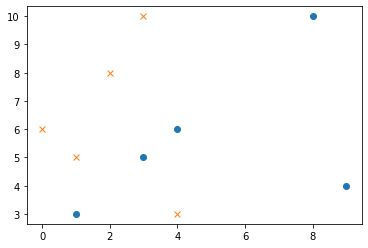

In [18]:
plt.plot(xpointsa, ypointsa, 'o')
plt.plot(xpointsb, ypointsb, 'x')
plt.show()